# Tweedie regression on insurance claims
## Agenda

- 保険契約テーブルデータを用いて、契約単位毎の支払保険金総額の期待値を導出する([here](https://scikit-learn.org/dev/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html#frequency-model-poisson-distribution))
- sklearnになれる


### Hardware

In [1]:
%%bash
system_profiler SPHardwareDataType | grep -E \
"Model Identifier"\|"Processor Name"\|"Processor Speed"\
\|"Number of Processors"\|"Memory:"

      Model Identifier: MacBookPro13,1
      Processor Name: Dual-Core Intel Core i5
      Processor Speed: 2 GHz
      Number of Processors: 1
      Memory: 16 GB


### Python

In [2]:
!python -V

Python 3.7.4


### Install packages

In [3]:
#!pip install --upgrade scikit-learn==0.23.1

### Import

In [4]:
from functools import partial
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer

from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PoissonRegressor, GammaRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

from sklearn.metrics import mean_absolute_error, mean_squared_error, auc, mean_poisson_deviance, mean_tweedie_deviance

## Question and Data
### Question

- 契約単位で、保険会社の支払い保険金金額の予測値を導出する。

### Data

- 保険会社の保険契約のデータセット (The French Motor Third-Party Liability Claims dataset)
- driver age, vehicle age, vehicle power, etc.がカラムに含まれている
- [source](https://www.openml.org/d/41214)

### Read Dataset part 1

- 契約内容のデータセットを取得

#### columns

- IDpol The policy ID (used to link with the claims dataset)
- ClaimNb Number of claims during the exposure period.
- Exposure The exposure period.
- Area The area code
- VehPower The power of the car (ordered categorical).
- VehAge The vehicle age, in years.
- DrivAge The driver age, in years (in France, people can drive a car at 18). 
- BonusMalus Bonus/malus, between 50 and 350: 100 means malus in France.
- VehBrand The car brand (unknown categories). 
- VehGas The car gas, Diesel or regular. 
- Density The density of inhabitants (number of inhabitants per km2) in the city the driver of the car lives in. 
- Region The policy regions in France (based on a standard French classification)



In [5]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df_freq = fetch_openml(data_id=41214, as_frame=True)['data']
df_freq.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
1,3.0,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
2,5.0,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22
3,10.0,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
4,11.0,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72


契約番号の前処理とindex化

In [6]:
df_freq['IDpol'] = df_freq['IDpol'].astype(int)
df_freq.set_index('IDpol', inplace=True)

### Read Dataset part 2
- claim dataの取得

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df_sev = fetch_openml(data_id=41215, as_frame=True)['data']
df_sev.head()

,IDpol,ClaimAmount
0,1552.0,995.20
1,1010996.0,1128.12
2,4024277.0,1851.11
3,4007252.0,1204.00
4,4046424.0,1204.00


契約番号の前処理

In [8]:
df_sev['IDpol'] = df_sev['IDpol'].astype(int)

In [9]:
df_sev['IDpol'].value_counts()

2262511    66
2282134    36
2227533    25
2220367    24
2277846    23
           ..
1162205     1
173022      1
3148642     1
4150240     1
1081344     1
Name: IDpol, Length: 24950, dtype: int64

契約別claimの合計の算出

In [10]:
df_sev = df_sev.groupby('IDpol').sum()

### 契約dataとクレームdataのmerge

- index-basedのmergeなので`join`を活用

In [11]:
df = df_freq.join(df_sev, how="left")
df["ClaimAmount"].fillna(0, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 678013 entries, 1 to 6114330
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   ClaimNb      678013 non-null  float64 
 1   Exposure     678013 non-null  float64 
 2   Area         678013 non-null  category
 3   VehPower     678013 non-null  float64 
 4   VehAge       678013 non-null  float64 
 5   DrivAge      678013 non-null  float64 
 6   BonusMalus   678013 non-null  float64 
 7   VehBrand     678013 non-null  category
 8   VehGas       678013 non-null  object  
 9   Density      678013 non-null  float64 
 10  Region       678013 non-null  category
 11  ClaimAmount  678013 non-null  float64 
dtypes: category(3), float64(8), object(1)
memory usage: 73.7+ MB


In [13]:
df.head()

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
IDpol,,,,,,,,,,,,
1,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
3,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
5,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,0.0
10,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0
11,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0


unquote stringの除去

In [14]:
# unquote string fields
for column_name in df.columns[df.dtypes.values == np.object]:
    df[column_name] = df[column_name].str.strip("'")

In [15]:
df.head()

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
IDpol,,,,,,,,,,,,
1,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
3,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
5,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,0.0
10,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0
11,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0


In [16]:
df.describe()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,6.780130e+05
mean,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405,8.835998e+01
std,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564,5.822454e+03
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000e+00
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000,0.000000e+00
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000e+00
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,0.000000e+00
max,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000,4.075401e+06


保険金支払っていないが`ClaimNb`がpositiveなケースが存在しないようにする

In [17]:
# requires strictly positive target values.
eps = 10e-6
df.loc[(abs(df["ClaimAmount"] - 0) < eps) & (df["ClaimNb"] >= 1.0), "ClaimNb"] = 0
df.head()

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
IDpol,,,,,,,,,,,,
1,0.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
3,0.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
5,0.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,0.0
10,0.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0
11,0.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0


In [18]:
# Insurances companies are interested in modeling the Pure Premium, that is
# the expected total claim amount per unit of exposure for each policyholder
# in their portfolio:
df["PurePremium"] = df["ClaimAmount"] / df["Exposure"]

# This can be indirectly approximated by a 2-step modeling: the product of the
# Frequency times the average claim amount per claim:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]
df["AvgClaimAmount"] = df["ClaimAmount"] / np.fmax(df["ClaimNb"], 1) ## elementwise max

### Outlierの除去

In [19]:
# Correct for unreasonable observations (that might be data error)
# and a few exceptionally large claim amounts
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)
df["ClaimAmount"] = df["ClaimAmount"].clip(upper=200000)

### Preprocessing

In [20]:
log_scale_transformer = make_pipeline(
    FunctionTransformer(func=np.log),
    StandardScaler()
)

column_trans = ColumnTransformer(
    [
        ("binned_numeric", KBinsDiscretizer(n_bins=10),
            ["VehAge", "DrivAge"]),
        ("onehot_categorical", OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"]),
        ("passthrough_numeric", "passthrough",
            ["BonusMalus"]),
        ("log_scaled_numeric", log_scale_transformer,
            ["Density"]),
    ],
    remainder="drop",
)

In [21]:
X = column_trans.fit_transform(df)

In [22]:
with pd.option_context("display.max_columns", 15):
    print(df[df.ClaimAmount > 0].head())

       ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
IDpol                                                                           
139        1.0      0.75    F       7.0     1.0     61.0        50.0      B12   
190        1.0      0.14    B      12.0     5.0     50.0        60.0      B12   
414        1.0      0.14    E       4.0     0.0     36.0        85.0      B12   
424        2.0      0.62    F      10.0     0.0     51.0       100.0      B12   
463        1.0      0.31    A       5.0     0.0     45.0        50.0      B12   

        VehGas  Density Region  ClaimAmount   PurePremium  Frequency  \
IDpol                                                                  
139    Regular  27000.0    R11       303.00    404.000000   1.333333   
190     Diesel     56.0    R25      1981.84  14156.000000   7.142857   
414    Regular   4792.0    R11      1456.55  10403.928571   7.142857   
424    Regular  27000.0    R11     10834.00  17474.193548   3.225806   


## Frequency model – Poisson distribution

```
Frequency = ClaimNb / Exposure
```

として、この`Frequency`のprediction modelを作成したいとする。

### 方針

- `ClaimNb`がポワソン分布に従っているとナイーブに仮定する
- `Exposure`でweightをとった形でGLMを実施する。

### EDA

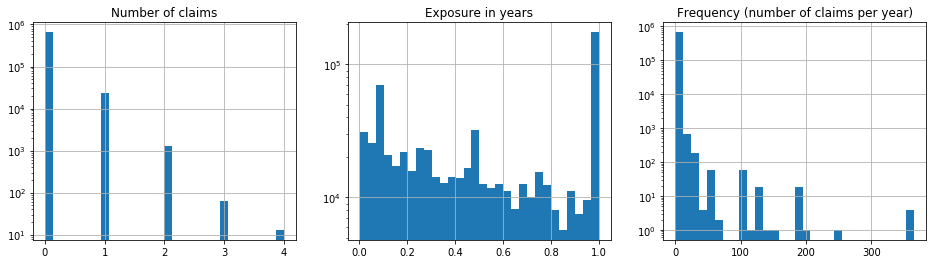

In [23]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 4))
ax0.set_title("Number of claims")
_ = df["ClaimNb"].hist(bins=30, log=True, ax=ax0)
ax1.set_title("Exposure in years")
_ = df["Exposure"].hist(bins=30, log=True, ax=ax1)
ax2.set_title("Frequency (number of claims per year)")
_ = df["Frequency"].hist(bins=30, log=True, ax=ax2)

In [24]:
print("Average Frequency = {}"
      .format(np.average(df["Frequency"])))

print("Weighted Average Frequency = {}"
      .format(np.average(df["Frequency"], weights=df["Exposure"])))

print("Fraction of exposure with zero claims = {0:.1%}"
      .format(df.loc[df["ClaimNb"] == 0, "Exposure"].sum() /
              df["Exposure"].sum()))

Average Frequency = 0.11862696859375195
Weighted Average Frequency = 0.07377842992512985
Fraction of exposure with zero claims = 95.2%


#### REMARK

- over 95% of the policyholderがzero claimsというimbalanced dataという特徴になっている
- 単純なモデルでも95% accuracyが達成できる


### A constant prediction baseline

- baselineとして、dummy estimatorを作成する
- dummy estimatorはtraining sampleのmean frequencyを出力するとする

In [25]:
df_train, df_test = train_test_split(df, test_size=0.33, random_state=42)

dummy = Pipeline([
    ("preprocessor", column_trans),
    ("regressor", DummyRegressor(strategy='mean')),
]).fit(df_train, df_train["Frequency"],
       regressor__sample_weight=df_train["Exposure"])

In [26]:
def score_estimator(estimator, df_test):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(df_test)

    print("MSE: %.3f" %
          mean_squared_error(df_test["Frequency"], y_pred,
                             sample_weight=df_test["Exposure"]))
    print("MAE: %.3f" %
          mean_absolute_error(df_test["Frequency"], y_pred,
                              sample_weight=df_test["Exposure"]))

    # Ignore non-positive predictions, as they are invalid for
    # the Poisson deviance.
    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(f"WARNING: Estimator yields invalid, non-positive predictions "
              f" for {n_masked} samples out of {n_samples}. These predictions "
              f"are ignored when computing the Poisson deviance.")

    print("mean Poisson deviance: %.3f" %
          mean_poisson_deviance(df_test["Frequency"][mask],
                                y_pred[mask],
                                sample_weight=df_test["Exposure"][mask]))


print("Constant mean frequency evaluation:")
score_estimator(dummy, df_test)

Constant mean frequency evaluation:
MSE: 0.260
MAE: 0.140
mean Poisson deviance: 0.480


### Model Building

In [27]:
def score_estimator(
    estimator, X_train, X_test, df_train, df_test, target, weights,
    tweedie_powers=None,
):
    """Evaluate an estimator on train and test sets with different metrics"""

    metrics = [
        ("D² explained", None),   # Use default scorer if it exists
        ("mean abs. error", mean_absolute_error),
        ("mean squared error", mean_squared_error),
    ]
    if tweedie_powers:
        metrics += [(
            "mean Tweedie dev p={:.4f}".format(power),
            partial(mean_tweedie_deviance, power=power)
        ) for power in tweedie_powers]

    res = []
    for subset_label, X, df in [
        ("train", X_train, df_train),
        ("test", X_test, df_test),
    ]:
        y, _weights = df[target], df[weights]
        for score_label, metric in metrics:
            if isinstance(estimator, tuple) and len(estimator) == 2:
                # Score the model consisting of the product of frequency and
                # severity models.
                est_freq, est_sev = estimator
                y_pred = est_freq.predict(X) * est_sev.predict(X)
            else:
                y_pred = estimator.predict(X)

            if metric is None:
                if not hasattr(estimator, "score"):
                    continue
                score = estimator.score(X, y, sample_weight=_weights)
            else:
                score = metric(y, y_pred, sample_weight=_weights)

            res.append(
                {"subset": subset_label, "metric": score_label, "score": score}
            )

    res = (
        pd.DataFrame(res)
        .set_index(["metric", "subset"])
        .score.unstack(-1)
        .round(4)
        .loc[:, ['train', 'test']]
    )
    return res


In [28]:
df_train, df_test, X_train, X_test = train_test_split(df, X, random_state=42)
glm_freq = PoissonRegressor(alpha=1e-3, max_iter=400)
glm_freq.fit(X_train, df_train["Frequency"],
             sample_weight=df_train["Exposure"])
scores = score_estimator(
    glm_freq,
    X_train,
    X_test,
    df_train,
    df_test,
    target="Frequency",
    weights="Exposure",
)
print("Evaluation of PoissonRegressor on target Frequency")
print(scores)

Evaluation of PoissonRegressor on target Frequency
subset               train    test
metric                            
D² explained        0.0442  0.0423
mean abs. error     0.1376  0.1388
mean squared error  0.2565  0.2388


#### plot model performance

In [29]:
def plot_obs_pred(df, feature, weight, observed, predicted, y_label=None,
                  title=None, ax=None, fill_legend=False):
    """Plot observed and predicted - aggregated per feature level.

    Parameters
    ----------
    df : DataFrame
        input data
    feature: str
        a column name of df for the feature to be plotted
    weight : str
        column name of df with the values of weights or exposure
    observed : str
        a column name of df with the observed target
    predicted : DataFrame
        a dataframe, with the same index as df, with the predicted target
    fill_legend : bool, default=False
        whether to show fill_between legend
    """
    # aggregate observed and predicted variables by feature level
    df_ = df.loc[:, [feature, weight]].copy()
    df_["observed"] = df[observed] * df[weight]
    df_["predicted"] = predicted * df[weight]
    df_ = (
        df_.groupby([feature])[[weight, "observed", "predicted"]]
        .sum()
        .assign(observed=lambda x: x["observed"] / x[weight])
        .assign(predicted=lambda x: x["predicted"] / x[weight])
    )

    ax = df_.loc[:, ["observed", "predicted"]].plot(style=".", ax=ax)
    y_max = df_.loc[:, ["observed", "predicted"]].values.max() * 0.8
    p2 = ax.fill_between(
        df_.index,
        0,
        y_max * df_[weight] / df_[weight].values.max(),
        color="g",
        alpha=0.1,
    )
    if fill_legend:
        ax.legend([p2], ["{} distribution".format(feature)])
    ax.set(
        ylabel=y_label if y_label is not None else None,
        title=title if title is not None else "Train: Observed vs Predicted",
    )



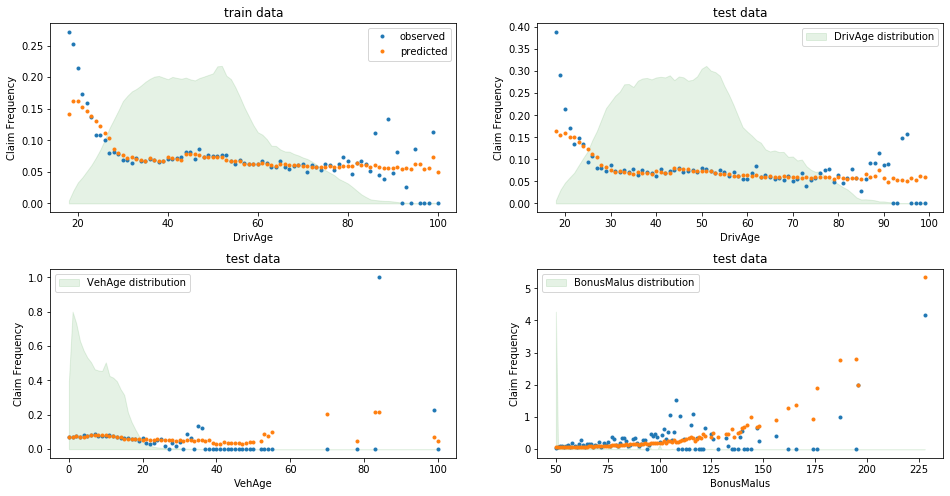

In [30]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

plot_obs_pred(
    df=df_train,
    feature="DrivAge",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_train),
    y_label="Claim Frequency",
    title="train data",
    ax=ax[0, 0],
)

plot_obs_pred(
    df=df_test,
    feature="DrivAge",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_test),
    y_label="Claim Frequency",
    title="test data",
    ax=ax[0, 1],
    fill_legend=True
)

plot_obs_pred(
    df=df_test,
    feature="VehAge",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_test),
    y_label="Claim Frequency",
    title="test data",
    ax=ax[1, 0],
    fill_legend=True
)

plot_obs_pred(
    df=df_test,
    feature="BonusMalus",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_test),
    y_label="Claim Frequency",
    title="test data",
    ax=ax[1, 1],
    fill_legend=True
)

## Severity Model - Gamma distribution

- `AvgClaimAmount` (Severity or the mean claim amount)は近似的にGamma Distributionに従うというRule of thumbsがある
- Frequency Model同様に同じfeaturesを用いてGLM modelを構築する

### 作業方針

- `ClaimAmount == 0`はfilter outする（Gamma Distributionのsupportは$(0, \infty)$のため）
- `ClaimNb`をsample_weightとして用いる


In [31]:
mask_train = df_train["ClaimAmount"] > 0
mask_test = df_test["ClaimAmount"] > 0

glm_sev = GammaRegressor(alpha=10., max_iter=10000)

glm_sev.fit(
    X_train[mask_train.values],
    df_train.loc[mask_train, "AvgClaimAmount"],
    sample_weight=df_train.loc[mask_train, "ClaimNb"],
)

scores = score_estimator(
    glm_sev,
    X_train[mask_train.values],
    X_test[mask_test.values],
    df_train[mask_train],
    df_test[mask_test],
    target="AvgClaimAmount",
    weights="ClaimNb",
)
print("Evaluation of GammaRegressor on target AvgClaimAmount")
print(scores)

Evaluation of GammaRegressor on target AvgClaimAmount
subset                     train          test
metric                                        
D² explained        5.640000e-02 -4.800000e-02
mean abs. error     2.263959e+03  2.261139e+03
mean squared error  1.034351e+09  1.749719e+08


### REMARK

- train dataとtest dataのgoodness of fitが大きく異なっている
- overfitの可能性を示唆している

In [32]:
print("Mean AvgClaim Amount per policy:              %.2f "
      % df_train["AvgClaimAmount"].mean())
print("Mean AvgClaim Amount | NbClaim > 0:           %.2f"
      % df_train["AvgClaimAmount"][df_train["AvgClaimAmount"] > 0].mean())
print("Predicted Mean AvgClaim Amount | NbClaim > 0: %.2f"
      % glm_sev.predict(X_train).mean())

Mean AvgClaim Amount per policy:              81.70 
Mean AvgClaim Amount | NbClaim > 0:           2230.72
Predicted Mean AvgClaim Amount | NbClaim > 0: 2052.89


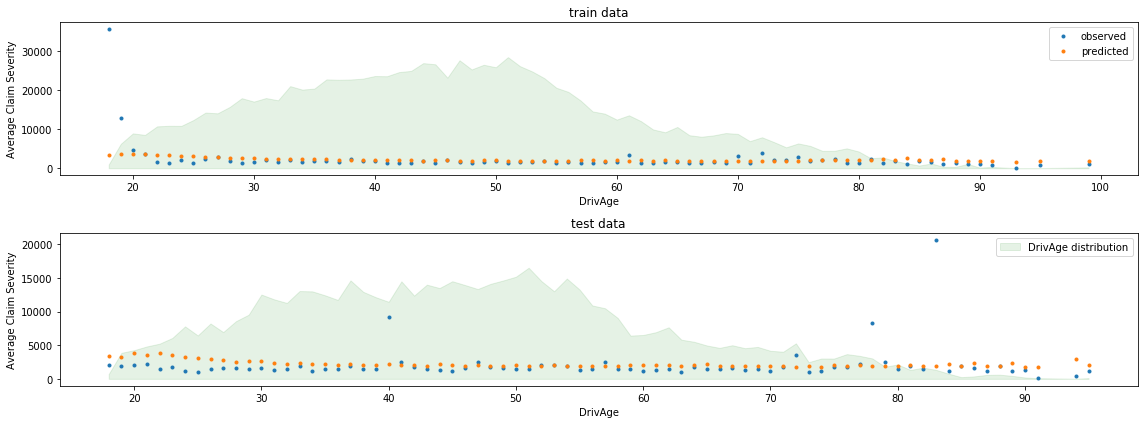

In [33]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16, 6))

plot_obs_pred(
    df=df_train.loc[mask_train],
    feature="DrivAge",
    weight="Exposure",
    observed="AvgClaimAmount",
    predicted=glm_sev.predict(X_train[mask_train.values]),
    y_label="Average Claim Severity",
    title="train data",
    ax=ax[0],
)

plot_obs_pred(
    df=df_test.loc[mask_test],
    feature="DrivAge",
    weight="Exposure",
    observed="AvgClaimAmount",
    predicted=glm_sev.predict(X_test[mask_test.values]),
    y_label="Average Claim Severity",
    title="test data",
    ax=ax[1],
    fill_legend=True
)
plt.tight_layout()

### REMARK

- `DrivAge`はthe claim severityのインパクトがないと解釈することができる

## Pure Premium Modeling via a Product Model vs single TweedieRegressor

- Compound Poisson-Gamma distribution of the total claim amountを仮定する
- Tweedie distribution with a power parameter between 1 and 2と同じ

### powerの探索の仕方

- grid searchでstep by stepで探索する


In [34]:
glm_pure_premium = TweedieRegressor(power=1.9, alpha=.1, max_iter=10000)
glm_pure_premium.fit(X_train, df_train["PurePremium"],
                     sample_weight=df_train["Exposure"])

tweedie_powers = [1.5, 1.7, 1.8, 1.9, 1.99, 1.999, 1.9999]

scores_product_model = score_estimator(
    (glm_freq, glm_sev),
    X_train,
    X_test,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

scores_glm_pure_premium = score_estimator(
    glm_pure_premium,
    X_train,
    X_test,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers
)

scores = pd.concat([scores_product_model, scores_glm_pure_premium],
                   axis=1, sort=True,
                   keys=('Product Model', 'TweedieRegressor'))
print("Evaluation of the Product Model and the Tweedie Regressor "
      "on target PurePremium")
with pd.option_context('display.expand_frame_repr', False):
    print(scores)

Evaluation of the Product Model and the Tweedie Regressor on target PurePremium
                          Product Model               TweedieRegressor              
subset                            train          test            train          test
D² explained                        NaN           NaN     2.850000e-02  7.100000e-03
mean Tweedie dev p=1.5000  7.981070e+01  8.476570e+01     7.873980e+01  8.574130e+01
mean Tweedie dev p=1.7000  3.752110e+01  3.920000e+01     3.719950e+01  3.955410e+01
mean Tweedie dev p=1.8000  3.070270e+01  3.167800e+01     3.052390e+01  3.189190e+01
mean Tweedie dev p=1.9000  3.398220e+01  3.453940e+01     3.388170e+01  3.466900e+01
mean Tweedie dev p=1.9900  2.016631e+02  2.018198e+02     2.016027e+02  2.019025e+02
mean Tweedie dev p=1.9990  1.915069e+03  1.913404e+03     1.915011e+03  1.913483e+03
mean Tweedie dev p=1.9999  1.905207e+04  1.903236e+04     1.905202e+04  1.903244e+04
mean abs. error            3.100746e+02  3.132743e+02     3.076609e+02

In [35]:
res = []
for subset_label, X, df in [
    ("train", X_train, df_train),
    ("test", X_test, df_test),
]:
    exposure = df["Exposure"].values
    res.append(
        {
            "subset": subset_label,
            "observed": df["ClaimAmount"].values.sum(),
            "predicted, frequency*severity model": np.sum(
                exposure * glm_freq.predict(X) * glm_sev.predict(X)
            ),
            "predicted, tweedie, power=%.2f"
            % glm_pure_premium.power: np.sum(
                exposure * glm_pure_premium.predict(X)),
        }
    )

print(pd.DataFrame(res).set_index("subset").T)

subset                                      train          test
observed                             3.801911e+07  1.415253e+07
predicted, frequency*severity model  4.471684e+07  1.487737e+07
predicted, tweedie, power=1.90       4.391249e+07  1.461653e+07


### REMARKS

- modelはunderestimateの傾向があることがわかる

### Policyholderのrank付け

- safest to riskiestにランク付けする
- rank付けの結果をx-axisをrank, y-axisをtotal claimとしてplotする(Lorenz curve)
- Gini indexを活用（monotonicityが重要）



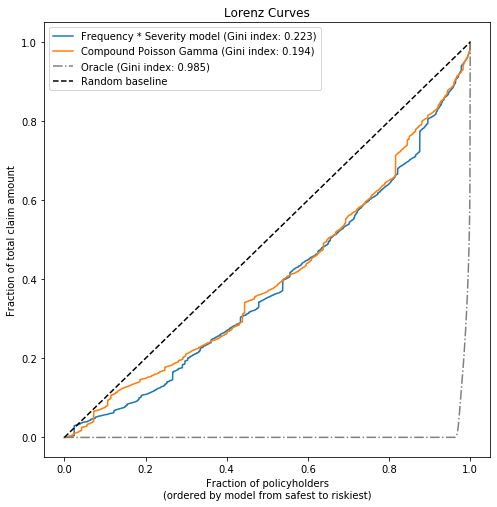

In [36]:
def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_exposure = exposure[ranking]
    ranked_pure_premium = y_true[ranking]
    cumulated_claim_amount = np.cumsum(ranked_pure_premium * ranked_exposure)
    cumulated_claim_amount /= cumulated_claim_amount[-1]
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))
    return cumulated_samples, cumulated_claim_amount


fig, ax = plt.subplots(figsize=(8, 8))

y_pred_product = glm_freq.predict(X_test) * glm_sev.predict(X_test)
y_pred_total = glm_pure_premium.predict(X_test)

for label, y_pred in [("Frequency * Severity model", y_pred_product),
                      ("Compound Poisson Gamma", y_pred_total)]:
    ordered_samples, cum_claims = lorenz_curve(
        df_test["PurePremium"], y_pred, df_test["Exposure"])
    gini = 1 - 2 * auc(ordered_samples, cum_claims)
    label += " (Gini index: {:.3f})".format(gini)
    ax.plot(ordered_samples, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
ordered_samples, cum_claims = lorenz_curve(
    df_test["PurePremium"], df_test["PurePremium"], df_test["Exposure"])
gini = 1 - 2 * auc(ordered_samples, cum_claims)
label = "Oracle (Gini index: {:.3f})".format(gini)
ax.plot(ordered_samples, cum_claims, linestyle="-.", color="gray",
        label=label)

# Random baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black",
        label="Random baseline")
ax.set(
    title="Lorenz Curves",
    xlabel=('Fraction of policyholders\n'
            '(ordered by model from safest to riskiest)'),
    ylabel='Fraction of total claim amount'
)
ax.legend(loc="upper left");